# Simulations starting with perfectly ordered dimer configuration

This function creates an ordered state of dimers in a triangular lattice. This can be used to explore the evolution of the system assuming it starts on a dimer state.

In [74]:
def ordered_dimers(n_of_particles = 150, packing=0.35, height = 4.1, r = 1.4, theta = 0, verbose = False):
    
    
    N_dimers = lambda Nt: np.round(Nt/2)

    N_columns = lambda Nt: np.round(np.sqrt(Nt)/2)*2
    N_rows = lambda Nt: np.round(Nt/N_columns(Nt))

    N_particles = 2*N_columns(N_dimers(n_of_particles))*N_rows(N_dimers(n_of_particles))

    if verbose:
        print("Creating %u particles; %u dimers \n"%(N_particles, N_particles/2))
        print("packing should be", packing)

    a = lambda phi: np.sqrt(8*np.pi/(phi*3**(3/2)))
    
    if verbose:
        print("The lattice constant is a = %2.3f"%a(packing))
        
    size = lambda phi,Nt: (N_columns(Nt)*a(phi),N_rows(Nt)*a(phi)*np.sqrt(3/4))
    
    def lattice(Nt):

        grid = np.meshgrid(
            np.arange(0,N_columns(Nt)),
            np.arange(0,N_rows(Nt)))

        primitive_vectors = np.array([[1,0],[1/2,np.sqrt(3/4)]])

        lattice = (grid[0]*primitive_vectors[0,0]+grid[1]*primitive_vectors[1,0],
                   grid[0]*primitive_vectors[0,1]+grid[1]*primitive_vectors[1,1])

        lattice = (np.mod(lattice[0],N_columns(Nt)),np.mod(lattice[1],N_rows(Nt)))

        return lattice[0]+0.25,lattice[1]+0.5*np.sqrt(3/4)
    
    h = height/r

    ps_in_dimer = np.array([
            [np.sqrt(h*(4-h))*np.cos(theta),
             np.sqrt(h*(4-h))*np.sin(theta),h-2],
            [-np.sqrt(h*(4-h))*np.cos(theta),
             -np.sqrt(h*(4-h))*np.sin(theta),2-h]])

    positions = lambda Nt,phi,rho: np.array(
            [[r*a(packing/2)*l1,r*a(packing/2)*l2,0] + p/rho
             for l1,l2 in zip(
                 lattice(N_dimers(Nt))[0].flatten(),
                 lattice(N_dimers(Nt))[1].flatten()) for p in ps_in_dimer ])
    
    def region(N_dimers,h) :
        regionsize = np.array(size(packing/2,N_dimers))
        regionsize = np.array([regionsize[0],regionsize[1],h])
        return regionsize
    
    region = region(N_dimers(N_particles),h)*r
    positions = positions(N_particles,packing,r)-np.append(region[0:2]/2,[0])
    
    if verbose:
        print("The region is ", region)
        print(len(positions)," positions created")
        region_a = region[0]*region[1]
        partic_a = 4/3*np.pi*r**2*len(positions)
        print("packing is actually %2.2f/%2.2f = %2.2f"%(partic_a,region_a,partic_a/region_a))

    return region, positions

Creating 144 particles; 72 dimers 

packing should be 0.15
The lattice constant is a = 5.678
The region is  [ 89.9427951   87.62933863   4.1       ]
144  positions created
packing is actually 1182.24/7881.63 = 0.15


(-49.468537307122446,
 49.468537307122446,
 -48.196136245529573,
 48.196136245529573)

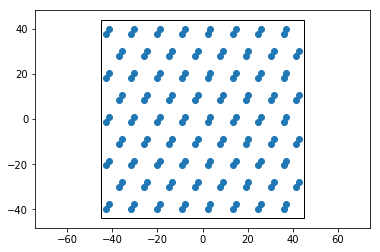

In [77]:
region, positions = ordered_dimers(n_of_particles = 150, packing=0.15, height = 4.1, r = 1.4, theta = np.pi/3,verbose= True)
plt.plot(positions[:,0],positions[:,1],'o')
plt.gca().add_patch(mpl.patches.Rectangle(-1/2*region[0:2],*region[0:2],fill=False))
plt.axis("equal")

# Run Simulation

In [78]:
import sys
import os
sys.path.insert(0, './magcolloids')
sys.path.insert(0, './confined-colloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import jsonpickle
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloid as mgc
import matplotlib as mpl
import lammps2d as lmp

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Starting from $\theta = 0$

In [93]:
region, positions = ordered_dimers(n_of_particles = 150, packing=0.4, height = 4.1, r = 1.4, theta = 0)

particles = mgc.particles(
    positions*ureg.um,
    radius = 1.4*ureg.um,
    susceptibility = 0.4,
    diffusion=0.073*ureg.um**2/ureg.s,
    density = 1000*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

In [94]:
field = mgc.field(magnitude = 7.28*ureg.mT, frequency = 0*ureg.Hz, angle = 0*ureg.degrees,multibody_iter=2)

world = mgc.world(particles, temperature = 300*ureg.K,
                  region=region.transpose().flatten()*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 30*ureg.um)

sim = mgc.sim(dir_name = "C:/Users/aortiza/Desktop/StartingFromOrderedDimer/",stamp_time=True,
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = 360*ureg.s,
       particles = particles, world = world, field = field, output=["x","y","z","mux","muy","muz","fx","fy"])

sim.generate_scripts()
sim.run()

In [95]:
sim.load()
trj = sim.lazy_read[::10]

In [96]:
HTML(mgc.display_animation_direct(sim,trj,start=0,end=360,step=10,speedup=10))

## Starting from $\theta = \frac{\pi}{3}$

Starting from $\theta = \frac{\pi}{3}$ should give the same result because it's within the lattice's six-fold symmetry. Instead we'll try $\theta = \frac{\pi}{6}$, which should avoid colinear neighbors. 

In [97]:
region, positions = ordered_dimers(n_of_particles = 150, packing=0.4, height = 4.1, r = 1.4, theta = np.pi/6)

particles = mgc.particles(
    positions*ureg.um,
    radius = 1.4*ureg.um,
    susceptibility = 0.4,
    diffusion=0.073*ureg.um**2/ureg.s,
    density = 1000*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

sim = mgc.sim(dir_name = "C:/Users/aortiza/Desktop/StartingFromOrderedDimer/",stamp_time=True,
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = 360*ureg.s,
       particles = particles, world = world, field = field, output=["x","y","z","mux","muy","muz","fx","fy"])

sim.generate_scripts()
sim.run()

In [98]:
sim.load()
trj = sim.lazy_read[::10]

In [99]:
HTML(mgc.display_animation_direct(sim,trj,start=0,end=360,step=10,speedup=10))

## Zero temperature

In [100]:
region, positions = ordered_dimers(n_of_particles = 150, packing=0.4, height = 4.1, r = 1.4, theta = 0)

particles = mgc.particles(
    positions*ureg.um,
    radius = 1.4*ureg.um,
    susceptibility = 0.4,
    diffusion=0.073*ureg.um**2/ureg.s,
    density = 1000*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

world = mgc.world(particles, temperature = 1*ureg.K,
                  region=region.transpose().flatten()*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 30*ureg.um)

sim = mgc.sim(dir_name = "C:/Users/aortiza/Desktop/StartingFromOrderedDimer/",stamp_time=True,
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = 360*ureg.s,
       particles = particles, world = world, field = field, output=["x","y","z","mux","muy","muz","fx","fy"])

sim.generate_scripts()
sim.run()

In [101]:
sim.load()
trj = sim.lazy_read[::10]

In [102]:
HTML(mgc.display_animation_direct(sim,trj,start=0,end=360,step=10,speedup=10))

In [103]:
region, positions = ordered_dimers(n_of_particles = 150, packing=0.4, height = 4.1, r = 1.4, theta = np.pi/6)

particles = mgc.particles(
    positions*ureg.um,
    radius = 1.4*ureg.um,
    susceptibility = 0.4,
    diffusion=0.073*ureg.um**2/ureg.s,
    density = 1000*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

world = mgc.world(particles, temperature = 1*ureg.K,
                  region=region.transpose().flatten()*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 30*ureg.um)

sim = mgc.sim(dir_name = "C:/Users/aortiza/Desktop/StartingFromOrderedDimer/",stamp_time=True,
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = 360*ureg.s,
       particles = particles, world = world, field = field, output=["x","y","z","mux","muy","muz","fx","fy"])

sim.generate_scripts()
sim.run()

In [104]:
sim.load()
trj = sim.lazy_read[::10]

In [105]:
HTML(mgc.display_animation_direct(sim,trj,start=0,end=360,step=10,speedup=10))

# Creation of the initial dimer function
Below here it's not very interesting. This describes the process I used to create the lattice

In [316]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

We might assume that dimers arrange themselves in a triangular lattice. We are given the same parameters as in the `initial_setup` function, the approximate number of particles $N_{target}$, the desired packing fraction $\phi$, the particle radius $r$ and the chamber height $h$

<img src=HexagonalOrdering.png width=800px>

In order to preserve boundary conditions, the previous figure shows how the number of rows must be even. The number of columns has no such restriction.

## Getting the lattice boundary size.
First, we obtain the number of dimers from the number of particles.

In [235]:
N_t = 240

N_dimers = lambda Nt: np.round(Nt/2)

N_dimers(N_t)

120.0

Then, we obtain the number of columns. To get a system that resembles a square as much as possible we define 

In [236]:
N_columns = lambda Nt: np.round(np.sqrt(Nt)/2)*2
N_columns(N_dimers(N_t))

10.0

Then we get the number of rows that yields the closest result to the target number of dimers

In [237]:
N_rows = lambda Nt: np.round(Nt/N_columns(Nt))
N_rows(N_dimers(N_t))

12.0

In [248]:
N_particles=  2*N_columns(N_dimers(N_t))*N_rows(N_dimers(N_t))

## Space size

To get the space size we need a lattice constant that will create a system with the expected packing fraction.

The total area $A$ of the system is equal to the number of particles multiplied by the area $A_h$ of a hexagon of apothem $\alpha = \frac{a}{2}$, where $a$ is the lattice constant. 

$$A = N_cN_rA_h$$

$$A = N_cN_r 2\sqrt{3}\alpha^2 = N_cN_r \frac{1}{2}\sqrt{3}a^2$$

The target packing fraction $\phi$ is the area occupied by the particles: $N_cN_rA_p$ divided by the area of the system $A$, where $A_p = \frac{4}{3}\pi\rho^2$ is the area of a single particle. This means:

$$\phi = \frac{N_cN_r\frac{4}{3}\pi\rho^2}{A}$$

$$\phi = \frac{N_cN_r\frac{4}{3}\pi\rho^2}{N_cN_r \frac{1}{2}\sqrt{3}a^2}$$

$$\phi = \frac{8\pi\rho^2}{3\sqrt{3}a^2}$$

And therefore, the lattice constant is:
$$\rho^2\sqrt{\frac{8\pi}{\phi3\sqrt{3}}} = a^2$$

In [368]:
N_particles*

1970.406912331518

In [369]:
N_particles*np.sqrt(3)/2*a(phi)**2

2872.3132832820966

In [370]:
rho = 1.4
phi = 0.35

In [371]:
a = lambda phi: np.sqrt(8*np.pi/(phi*3**(3/2)))
rho*a(phi)

5.2044279710548071

The width $s_x$ of the box is 
$$s_x = N_ca$$
The height $s_y$ is:
$$s_y = N_ra\sin\left(\frac{\pi}{3}\right) = N_ca\sqrt{\frac{3}{4}}$$


In [372]:
size = lambda phi,Nt: (N_columns(Nt)*a(phi),N_rows(Nt)*a(phi)*np.sqrt(3/4))

size(phi,N_t)

(59.479176812054938, 48.291073233211776)

# Finding central positions for the dimers

$$\vec{R} = n_1 \vec{a_1} + n_2 \vec{a_2}$$

In [561]:
def lattice(Nt):

    grid = np.meshgrid(
        np.arange(0,N_columns(Nt)),
        np.arange(0,N_rows(Nt)))
        
    primitive_vectors = np.array([[1,0],[1/2,np.sqrt(3/4)]])
    
    lattice = (grid[0]*primitive_vectors[0,0]+grid[1]*primitive_vectors[1,0],
               grid[0]*primitive_vectors[0,1]+grid[1]*primitive_vectors[1,1])
    
    lattice = (np.mod(lattice[0],N_columns(Nt)),np.mod(lattice[1],N_rows(Nt)))
    
    return (lattice[0]+0.25,lattice[1]+0.5*np.sqrt(3/4))

(-3.7174485507534336,
 78.066419565822102,
 -3.8632858586569423,
 81.129003031795776)

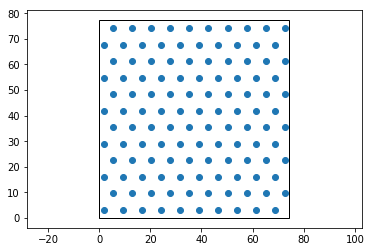

In [562]:
plt.plot(2*a(phi)*lattice(N_dimers(N_t))[0].flatten(),2*a(phi)*lattice(N_dimers(N_t))[1].flatten(),'o')

RegionSize = 2*np.array(size(phi,N_dimers(N_particles)))

plt.gca().add_patch(mpl.patches.Rectangle([0,0],*RegionSize,fill=False))
plt.axis("equal")

#plt.xlim(0,size(phi,N_particles)[0])
#plt.ylim(0,size(phi,N_particles)[1])

#plt.xlim(0,12)
#plt.ylim(0,10*np.sqrt(3/4))

In [65]:
ParticleArea = 2*len(lattice(N_dimers(N_t))[0].flatten())*4/3*np.pi*rho**2
ParticleArea

NameError: name 'lattice' is not defined

In [564]:
RegionArea = np.prod(RegionSize)
RegionArea

5744.6265665641931

In [565]:
ParticleArea/RegionArea

0.34299999999999997

# Find dimer components positions

<img src=Dobnikar_Geometry.png width=300px>

The vector that joins the lower coloid to the upper colloid is:
$$\vec{r} = [r_t,0,h-2\rho]$$
For the two particles to be a dimer we need:
$$\left|\vec{r}\right| = 2\rho$$

$$\left|\vec{r}\right| = \sqrt{r_t^2+(h-2\rho)^2} = 2\rho$$

$$r_t^2 = 4\rho^2-(h-2\rho)^2 $$
$$r_t^2 = 4\rho^2-h^2+4h\rho-4\rho^2 $$
$$r_t^2 = 4h\rho-h^2 $$

$$\vec{r} = \left[\sqrt{4h\rho-h^2},0,h-2\rho\right]$$

If we place everything in units of $\rho$ we get:
$$\frac{\vec{r}}{\rho} = \left[\sqrt{\frac{h}{\rho}\left(4-\frac{h}{\rho}\right)},0,\frac{h}{\rho}-2\right]$$


If we allow all dimers to be rotated at an angle $\phi$ (new parameter) we can define the vectors from the center to the dimer to each of the colloids as:

In [566]:
N_t=240

In [681]:
theta = np.pi/3
h = 3.5 # relative height

ps_in_dimer = np.array([
        [np.sqrt(h*(4-h))*np.cos(theta),
         np.sqrt(h*(4-h))*np.sin(theta),h-2],
        [-np.sqrt(h*(4-h))*np.cos(theta),
         -np.sqrt(h*(4-h))*np.sin(theta),2-h]])

positions = lambda Nt,phi,rho: np.array(
        [[2*a(phi)*l1,2*a(phi)*l2,0] + p/rho
         for l1,l2 in zip(
             lattice(N_dimers(N_t))[0].flatten(),
             lattice(N_dimers(N_t))[1].flatten()) for p in ps_in_dimer ])

In [682]:
ps_in_dimer

array([[ 0.66143783,  1.14564392,  1.5       ],
       [-0.66143783, -1.14564392, -1.5       ]])

In [683]:
RegionSize = rho*2*np.array(size(phi,N_dimers(N_particles)))
RegionSize = np.array([RegionSize[0],RegionSize[1],h*rho])

Region = RegionSize/2*np.array([[-1],[1]])
display(RegionSize)
display(Region)

array([ 104.08855942,  108.17200404,    4.9       ])

array([[-52.04427971, -54.08600202,  -2.45      ],
       [ 52.04427971,  54.08600202,   2.45      ]])

In [684]:
pos = rho*positions(N_dimers(N_t),phi,rho)+np.append(Region[0,0:2],[0])
lat = np.array([[l1,l2] for l1,l2 in 
                zip(
                    rho*2*a(phi)*lattice(N_dimers(N_t))[0].flatten(),
                    rho*2*a(phi)*lattice(N_dimers(N_t))[1].flatten())])+Region[0,0:2]

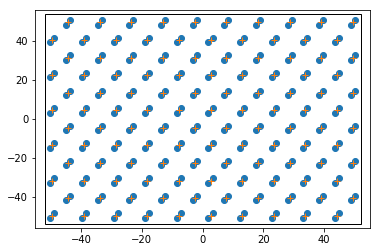

In [685]:
plt.plot(pos[:,0],pos[:,1],'o')
plt.plot(lat[:,0],lat[:,1],'+')

plt.gca().add_patch(mpl.patches.Rectangle(Region[0,0:2],*RegionSize[0:2],fill=False))

In [573]:
ps_in_dimer

array([[ 0.66143783,  1.14564392,  1.5       ],
       [-0.66143783, -1.14564392, -1.5       ]])

In [208]:
positions(N_dimers(N_t),phi)

array([[  1.22464680e-16,   2.00000000e+00,   0.00000000e+00],
       [ -1.22464680e-16,  -2.00000000e+00,   0.00000000e+00],
       [  1.85872428e+00,   2.00000000e+00,   0.00000000e+00],
       [  1.85872428e+00,  -2.00000000e+00,   0.00000000e+00],
       [  9.29362138e-01,   3.60970244e+00,   0.00000000e+00],
       [  9.29362138e-01,  -3.90297559e-01,   0.00000000e+00],
       [  2.78808641e+00,   3.60970244e+00,   0.00000000e+00],
       [  2.78808641e+00,  -3.90297559e-01,   0.00000000e+00],
       [  1.85872428e+00,   5.21940488e+00,   0.00000000e+00],
       [  1.85872428e+00,   1.21940488e+00,   0.00000000e+00],
       [  1.22464680e-16,   5.21940488e+00,   0.00000000e+00],
       [ -1.22464680e-16,   1.21940488e+00,   0.00000000e+00]])

In [214]:
[lattice(N_dimers(N_t),phi)[0].flatten(),lattice(N_dimers(N_t),phi)[1]]

[array([ 0.        ,  1.85872428,  0.92936214,  2.78808641,  1.85872428,  0.        ]),
 array([[ 0.        ,  0.        ],
        [ 1.60970244,  1.60970244],
        [ 3.21940488,  3.21940488]])]

In [690]:
def ordered_dimers(n_of_particles = 150, packing=0.35, height = 4.1, r = 1.4, theta = 0, verbose = False):
    
    
    N_dimers = lambda Nt: np.round(Nt/2)

    N_columns = lambda Nt: np.round(np.sqrt(Nt)/2)*2
    N_rows = lambda Nt: np.round(Nt/N_columns(Nt))

    print(N_dimers(n_of_particles))
    print(N_columns(N_dimers(n_of_particles)))
    print(N_rows(N_dimers(n_of_particles)))
    N_particles = 2*N_columns(N_dimers(n_of_particles))*N_rows(N_dimers(n_of_particles))

    if verbose:
        print("Creating %u particles; %u dimers \n"%(N_particles, N_particles/2))

    a = lambda phi: np.sqrt(8*np.pi/(phi*3**(3/2)))
    
    if verbose:
        print("The lattice constant is a = %2.3f"%a(packing))
        
    size = lambda phi,Nt: (N_columns(Nt)*a(packing),N_rows(Nt)*a(packing)*np.sqrt(3/4))
    
    def lattice(Nt):

        grid = np.meshgrid(
            np.arange(0,N_columns(Nt)),
            np.arange(0,N_rows(Nt)))

        primitive_vectors = np.array([[1,0],[1/2,np.sqrt(3/4)]])

        lattice = (grid[0]*primitive_vectors[0,0]+grid[1]*primitive_vectors[1,0],
                   grid[0]*primitive_vectors[0,1]+grid[1]*primitive_vectors[1,1])

        lattice = (np.mod(lattice[0],N_columns(Nt)),np.mod(lattice[1],N_rows(Nt)))

        return lattice[0]+0.25,lattice[1]+0.5*np.sqrt(3/4)
    
    h = height/r

    ps_in_dimer = np.array([
            [np.sqrt(h*(4-h))*np.cos(theta),
             np.sqrt(h*(4-h))*np.sin(theta),h-2],
            [-np.sqrt(h*(4-h))*np.cos(theta),
             -np.sqrt(h*(4-h))*np.sin(theta),2-h]])

    positions = lambda Nt,phi,rho: np.array(
            [[rho*2*a(packing)*l1,rho*2*a(packing)*l2,0] + p/rho
             for l1,l2 in zip(
                 lattice(N_dimers(Nt))[0].flatten(),
                 lattice(N_dimers(Nt))[1].flatten()) for p in ps_in_dimer ])
    
    def region(N_dimers,h) :
        regionsize = 2*np.array(size(packing,N_dimers))
        regionsize = np.array([regionsize[0],regionsize[1],h])
        return regionsize
    
    region = region(N_dimers(N_particles),h)*rho
    positions = positions(N_particles,phi,rho)-np.append(region[0:2]/2,[0])
    
    if verbose:
        print(len(positions)," positions created")

    return region, positions

In [24]:
region, positions = ordered_dimers(n_of_particles = 240, packing=0.35, height = 4.1, r = 1.4, theta = np.pi/4,verbose = True)

Creating 240 particles; 120 dimers 

The lattice constant is a = 3.717
240  positions created


NameError: name 'mpl' is not defined

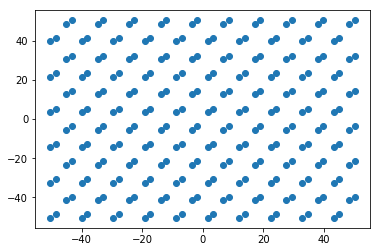

In [25]:
plt.plot(positions[:,0],positions[:,1],'o')

plt.gca().add_patch(mpl.patches.Rectangle(-1/2*region[0:2],*region[0:2],fill=False))

240  positions created
region size is:  [ 104.08855942  108.17200404    4.1       ]
Int64Index([0], dtype='int64', name='frame') 0


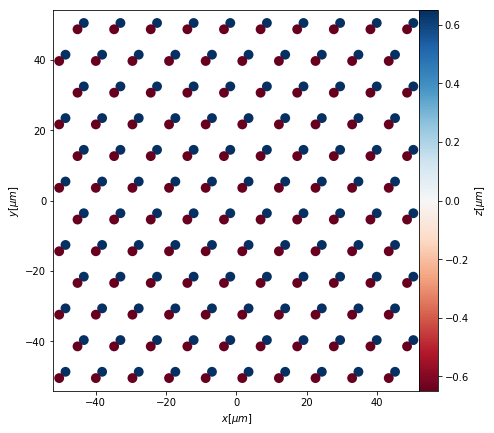

In [693]:
print(len(positions)," positions created")
print("region size is: ",region)

world = mgc.world(particles, temperature = 300*ureg.K,
                  region=region.transpose().flatten()*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 30*ureg.um)

sim = mgc.sim(dir_name = "C:/Users/aortiza/Desktop/Test2/",
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = 10*ureg.s,
       particles = particles, world = world, field = field, output=["x","y","z","mux","muy","muz","fx","fy"])

sim.generate_scripts()

trj = pd.DataFrame(data=positions,index=np.arange(len(positions)),columns = ["x","y","z"])
trj["frame"] = 0
trj["id"] = np.arange(len(positions))
trj = trj.set_index(["frame","id"])

mgc.draw_trj(trj,sim,iframe=0,ax=False)